In [2]:
from pysidt import Datum, SubgraphIsomorphicDecisionTree, write_nodes, read_nodes
from pysidt.extensions import split_mols
from pysidt.plotting import plot_tree
import logging
from molecule.molecule import Molecule,Group
from molecule.molecule.atomtype import ATOMTYPES
from molecule.kinetics import SurfaceArrhenius
from molecule.kinetics.uncertainties import RateUncertainty
from molecule.quantity import ScalarQuantity
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Prepare Training Data

In [3]:
#Surface diffusion mean field rate coefficients on Cu111 computed from Pynta
diff_dict = {
    '1    C u0 p0 c0 {2,S} {3,S} {4,S} {5,S}\n2    H u0 p0 c0 {1,S}\n3    H u0 p0 c0 {1,S}\n4    H u0 p0 c0 {1,S}\n5 *1 O u0 p2 c0 {1,S} {6,S}\n6 *2 X u0 p0 c0 {5,S}\n7 *3 X u0 p0 c0\n': 
    SurfaceArrhenius(A=(2.2223e-07,'m^2/(molecule*s)'), n=0.0174829, Ea=(15.6635,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K')),
    '1    N u0 p1 c0 {2,S} {3,S} {4,S}\n2    H u0 p0 c0 {1,S}\n3    H u0 p0 c0 {1,S}\n4    C u0 p0 c0 {1,S} {5,S} {6,D}\n5    H u0 p0 c0 {4,S}\n6 *1 C u0 p0 c0 {4,D} {7,S} {8,S}\n7    H u0 p0 c0 {6,S}\n8 *2 X u0 p0 c0 {6,S}\n9 *3 X u0 p0 c0\n':
    SurfaceArrhenius(A=(5.13926e-10,'m^2/(molecule*s)'), n=1.01787, Ea=(10.2887,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.00322, dn = +|- 0.000407601, dEa = +|- 0.00283132 kJ/mol"""),
    '1    O u0 p2 c0 {2,D}\n2 *1 C u0 p0 c0 {1,D} {3,D}\n3 *2 X u0 p0 c0 {2,D}\n4 *3 X u0 p0 c0\n':
    SurfaceArrhenius(A=(2.78393e-08,'m^2/(molecule*s)'), n=0.0503798, Ea=(4.61439,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.00513, dn = +|- 0.000648231, dEa = +|- 0.00450281 kJ/mol"""),
    '1 *1 O u0 p2 c0 {2,D}\n2 *2 X u0 p0 c0 {1,D}\n3 *3 X u0 p0 c0\n':
    SurfaceArrhenius(A=(4.36036e-07,'m^2/(molecule*s)'), n=0.0110633, Ea=(27.0082,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.00512, dn = +|- 0.000646724, dEa = +|- 0.00449234 kJ/mol"""),
    '1 *1 N u0 p1 c0 {2,T}\n2 *2 X u0 p0 c0 {1,T}\n3 *3 X u0 p0 c0\n':
    SurfaceArrhenius(A=(5.22663e-07,'m^2/(molecule*s)'), n=0.0171004, Ea=(17.9096,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.00831, dn = +|- 0.00104785, dEa = +|- 0.0072787 kJ/mol"""),
    '1 *1 O u0 p2 c0 {2,S} {3,S}\n2    H u0 p0 c0 {1,S}\n3 *2 X u0 p0 c0 {1,S}\n4 *3 X u0 p0 c0\n':
    SurfaceArrhenius(A=(2.6936e-07,'m^2/(molecule*s)'), n=-0.024542, Ea=(13.3305,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.00955, dn = +|- 0.00120318, dEa = +|- 0.00835765 kJ/mol"""),
    '1 *1 N u0 p1 c0 {2,S} {3,D}\n2    H u0 p0 c0 {1,S}\n3 *2 X u0 p0 c0 {1,D}\n4 *3 X u0 p0 c0\n':
    SurfaceArrhenius(A=(4.69378e-07,'m^2/(molecule*s)'), n=0.00356855, Ea=(22.6721,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.00213, dn = +|- 0.000270019, dEa = +|- 0.00187564 kJ/mol"""),
    '1    O u0 p2 c0 {2,D}\n2 *1 C u0 p0 c0 {1,D} {3,S} {4,S}\n3    H u0 p0 c0 {2,S}\n4 *2 X u0 p0 c0 {2,S}\n5 *3 X u0 p0 c0\n':
    SurfaceArrhenius(A=(1.18904e-07,'m^2/(molecule*s)'), n=0.0763068, Ea=(1.53955,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.01967, dn = +|- 0.00246664, dEa = +|- 0.017134 kJ/mol"""),
    '1 *1 H u0 p0 c0 {2,S}\n2 *2 X u0 p0 c0 {1,S}\n3 *3 X u0 p0 c0\n':
    SurfaceArrhenius(A=(8.66e-07,'m^2/(molecule*s)'), n=0.019382, Ea=(12.4395,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.02604, dn = +|- 0.00325525, dEa = +|- 0.022612 kJ/mol"""), 
}

In [4]:
len(diff_dict)

9

In [5]:
training_data = []
for adjlist,kin in diff_dict.items():
    d = Datum(Molecule().from_adjacency_list(adjlist), kin)
    training_data.append(d)

Class for Surface Diffusion Estimation

In [6]:
class SurfaceDiffusionEstimator(SubgraphIsomorphicDecisionTree):
    
    def choose_extension(self, node, exts):
        """
        select best extension among the set of extensions
        returns a Node object
        almost always subclassed
        """
        Tref = 1000.0
        minval = np.inf
        minext = None
        for ext in exts:
            new,comp = split_mols(node.items, ext)
            val = np.std([np.log(x.value.get_rate_coefficient(T=Tref)) for x in new])*len(new) + np.std([np.log(x.value.get_rate_coefficient(T=Tref)) for x in comp])*len(comp)
            if val < minval:
                minval = val 
                minext = ext 
        
        return minext
    
    def fit_tree(self, data=None):
        """
        fit rule for each node
        """
        Tref = 1000.0
        fmax = 1.0e5
        if data:
            self.clear_data()
            self.root.items = data[:]
            self.descend_training_from_top(only_specific_match=False)
        
        for node in self.nodes.values():
            if len(node.items) == 0:
                logging.error(node.name)
                raise ValueError
                
            node.rule = average_kinetics(node.items)
            
            data_mean = np.mean(np.log([k.value.get_rate_coefficient(Tref) for k in node.items]))
            n = len(node.items)
            
            if len(node.items) == 1:
                node.rule.uncertainty = RateUncertainty(mu=0.0, var=(np.log(fmax) / 2.0) ** 2, N=1, Tref=Tref, data_mean=data_mean, correlation=node.name)
                node.rule.comment = f"Only one reaction rate"
            else:
                dlnks = np.array([
                    np.log(average_kinetics([node.items[k] for k in list(set(range(len(node.items)))-{i})]).get_rate_coefficient(Tref) / 
                          node.items[i].value.get_rate_coefficient(Tref)) for i in range(len(node.items))
                ])
                mu = np.mean(dlnks)
                s = np.std(dlnks)
                node.rule.uncertainty = RateUncertainty(mu=mu, var=s ** 2, N=n, Tref=Tref, data_mean=data_mean, correlation=node.name)
        
    def evaluate(self, mol):
        """
        Evaluate tree for a given possibly labeled mol
        """
        children = self.root.children 
        node = self.root
        
        while children != []:
            for child in children:
                if mol.is_subgraph_isomorphic(child.group, generate_initial_map=True, save_order=True):
                    children = child.children 
                    node = child
                    break
            else:
                break

        while node.parent is not None:
            err_parent = abs(node.parent.rule.uncertainty.data_mean + node.parent.rule.uncertainty.mu - node.parent.rule.uncertainty.data_mean) + np.sqrt(2.0*node.parent.rule.uncertainty.var/np.pi)
            err_entry = abs(node.rule.uncertainty.mu) + np.sqrt(2.0*node.rule.uncertainty.var/np.pi)
            if err_entry <= err_parent:
                break
            else:
                node = node.parent
        
        return node.rule

def average_kinetics(items):
    Aunits = items[0].value.A.units
    
    if Aunits in {'cm^3/(mol*s)', 'cm^3/(molecule*s)', 'm^3/(molecule*s)'}:
        Aunits = 'm^3/(mol*s)'
    elif Aunits in {'cm^6/(mol^2*s)', 'cm^6/(molecule^2*s)', 'm^6/(molecule^2*s)'}:
        Aunits = 'm^6/(mol^2*s)'
    elif Aunits in {'s^-1', 'm^3/(mol*s)', 'm^6/(mol^2*s)'}:
        # they were already in SI
        pass
    elif Aunits in {'m^2/(mol*s)', 'cm^2/(mol*s)', 'm^2/(molecule*s)', 'cm^2/(molecule*s)'}:
        # surface: bimolecular (Langmuir-Hinshelwood)
        Aunits = 'm^2/(mol*s)'
    elif Aunits in {'m^5/(mol^2*s)', 'cm^5/(mol^2*s)', 'm^5/(molecule^2*s)', 'cm^5/(molecule^2*s)'}:
        # surface: dissociative adsorption
        Aunits = 'm^5/(mol^2*s)'
    elif Aunits == '':
        # surface: sticking coefficient
        pass
    else:
        raise ValueError(f'Invalid units {Aunits} for averaging kinetics.')
    
    A = np.exp(sum(np.log(d.value.A.value_si) for d in items)/len(items))
    n = sum(d.value.n.value_si for d in items)/len(items)
    Ea = sum(d.value.Ea.value_si for d in items)/len(items)
    return SurfaceArrhenius(A=(A,Aunits), n=n, Ea=(Ea,"J/mol"))

Generate Tree

In [7]:
root = Group().from_adjacency_list('1 *1 R u0 px cx {2,[S,D,T,Q]}\n2 *2 X u0 p0 c0 {1,[S,D,T,Q]}\n3 *3 X u0 p0 c0\n')
sidt = SurfaceDiffusionEstimator(root_group=root,
            r=[ATOMTYPES[x] for x in ["X","H","C","O","N"]], r_bonds=[1,2,3,1.5,4,0.0],
                                                         r_un=[0])

In [8]:
sidt.generate_tree(data=training_data)

INFO:root:Selected node Root
INFO:root:Node has 9 items
INFO:root:Choose extension Root_Sp-2X=1R
INFO:root:Selected node Root_Sp-2X=1R
INFO:root:Node has 3 items
INFO:root:Choose extension Root_Sp-2X=1R_1O->N
INFO:root:Selected node Root_N-Sp-2X=1R
INFO:root:Node has 6 items
INFO:root:Choose extension Root_N-Sp-2X=1R_1C->O
INFO:root:Selected node Root_Sp-2X=1R_N-1O->N
INFO:root:Node has 2 items
INFO:root:Choose extension Root_Sp-2X=1R_N-1O->N_1CHO->O
INFO:root:Selected node Root_N-Sp-2X=1R_1C->O
INFO:root:Node has 2 items
INFO:root:Choose extension Root_N-Sp-2X=1R_1C->O_Ext-1O-R
INFO:root:Selected node Root_N-Sp-2X=1R_N-1C->O
INFO:root:Node has 4 items
INFO:root:Choose extension Root_N-Sp-2X=1R_N-1C->O_1C->N
INFO:root:Selected node Root_N-Sp-2X=1R_N-1C->O_N-1C->N
INFO:root:Node has 3 items
INFO:root:Choose extension Root_N-Sp-2X=1R_N-1C->O_N-1C->N_1CH->H
INFO:root:Selected node Root_N-Sp-2X=1R_N-1C->O_N-1C->N_N-1CH->H
INFO:root:Node has 2 items
INFO:root:Choose extension Root_N-Sp-2X=1

In [9]:
sidt.fit_tree(data=training_data)

Visualize Tree

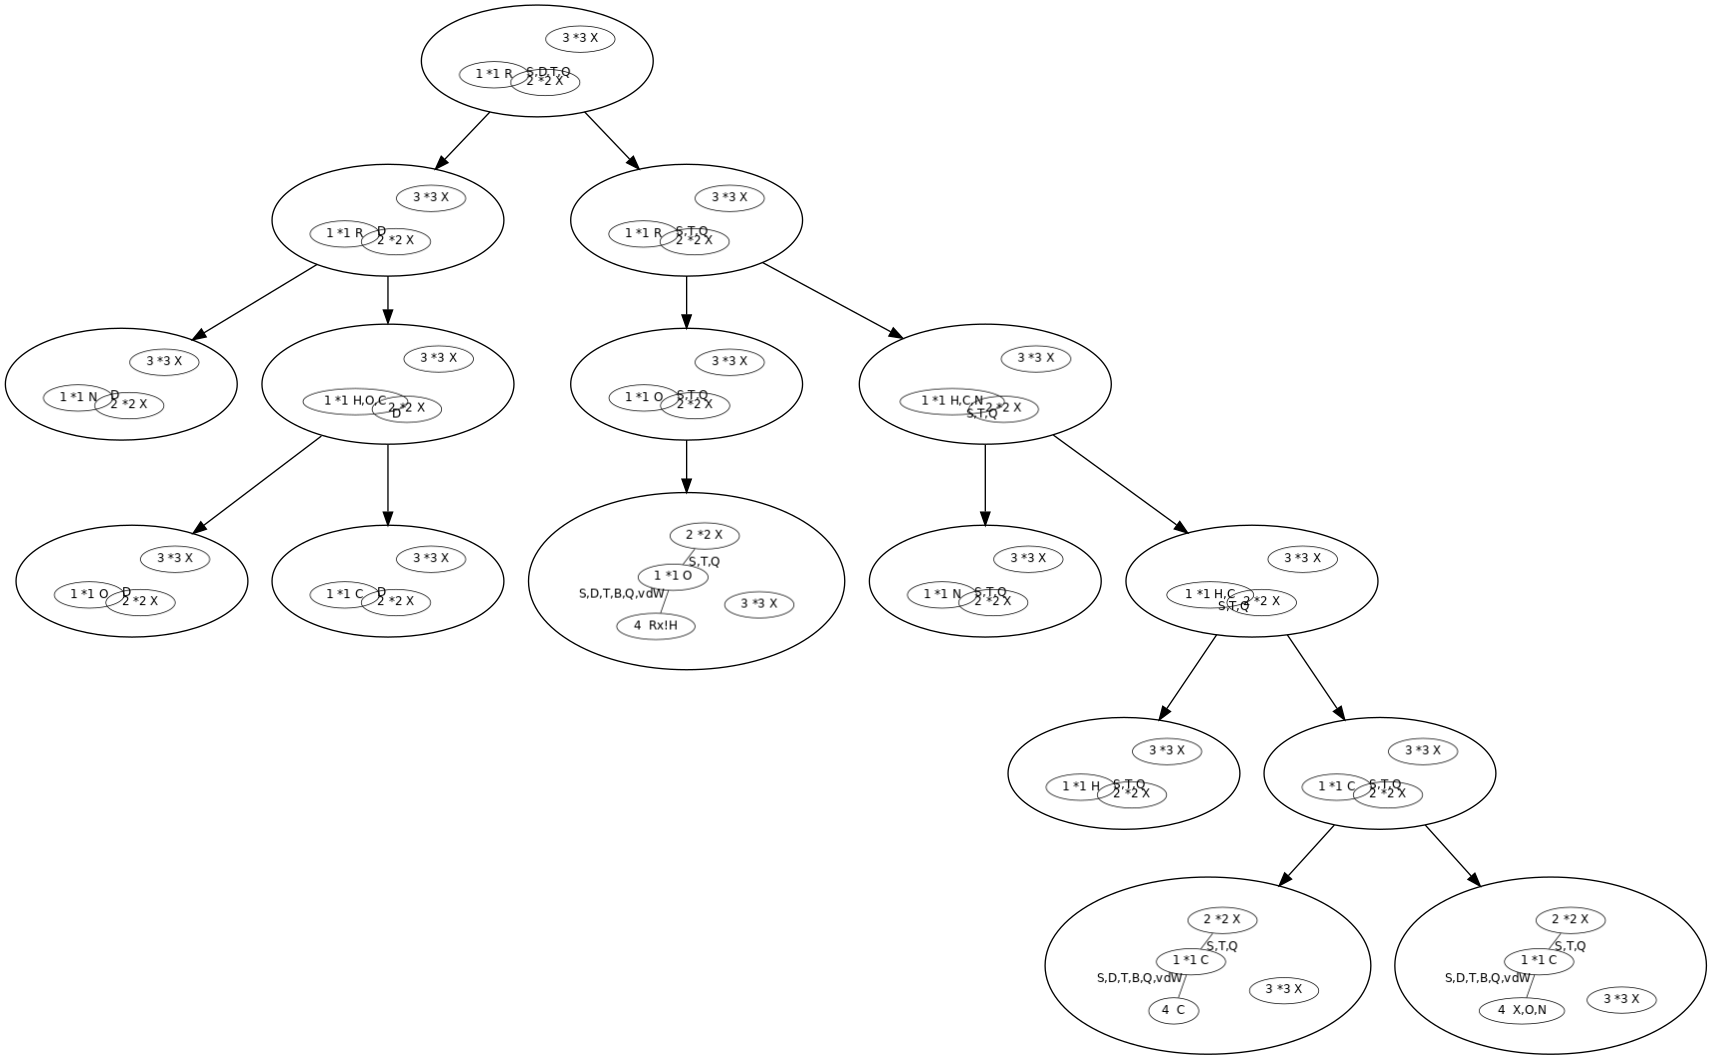

In [10]:
plot_tree(sidt, images=True)

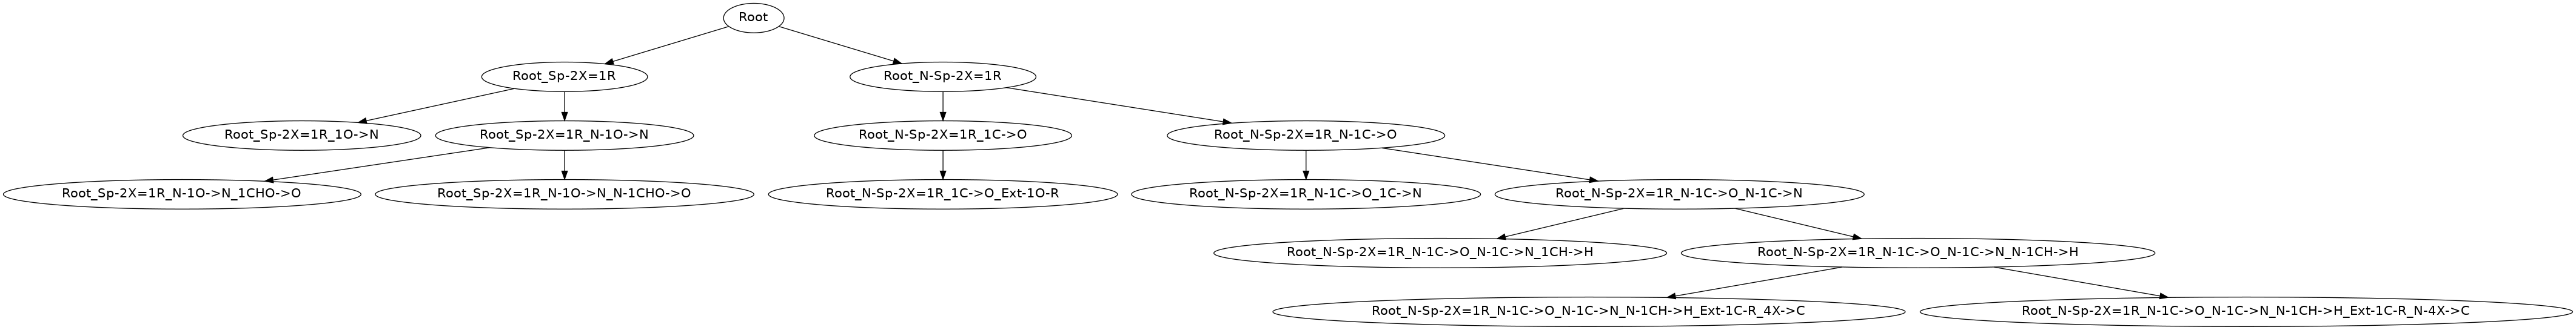

In [11]:
plot_tree(sidt, images=False)

Tree Evaluation Example

In [12]:
m = Molecule().from_adjacency_list("""
1 H u0 p0 c0 {2,S}
2 O u0 p2 c0 {1,S} {3,S}
3 *1 O u0 p2 c0 {2,S} {4,S}
4 *2 X u0 p0 c0 {3,S}
5 *3 X u0 p0 c0
""")

In [13]:
out = sidt.evaluate(m)

In [14]:
out

SurfaceArrhenius(A=(1.47339e+17,'m^2/(mol*s)'), n=-0.00352955, Ea=(14497,'J/mol'), T0=(1,'K'), uncertainty=RateUncertainty(mu=-2.2343238370581275e-15, var=0.033354906245902274, Tref=1000.0, N=2, data_mean=0.0, correlation='Root_N-Sp-2X=1R_1C->O',))

In [15]:
out.uncertainty

RateUncertainty(mu=-2.2343238370581275e-15, var=0.033354906245902274, Tref=1000.0, N=2, data_mean=0.0, correlation='Root_N-Sp-2X=1R_1C->O',)

Analyze Accuracy

In [16]:
def evaluate_one_node_up(sidt, mol):
    """
    Evaluate tree except that if the node was defined by a single reaction move one node up
    """
    children = sidt.root.children 
    node = sidt.root
    
    while children != []:
        for child in children:
            if mol.is_subgraph_isomorphic(child.group, generate_initial_map=True, save_order=True):
                children = child.children 
                node = child
                break
        else:
            break

    while node.parent is not None:
        err_parent = abs(node.parent.rule.uncertainty.data_mean + node.parent.rule.uncertainty.mu - node.parent.rule.uncertainty.data_mean) + np.sqrt(2.0*node.parent.rule.uncertainty.var/np.pi)
        err_entry = abs(node.rule.uncertainty.mu) + np.sqrt(2.0*node.rule.uncertainty.var/np.pi)
        if err_entry <= err_parent:
            break
        else:
            node = node.parent
    
    if node.children:
        return node.rule
    else:
        return node.parent.rule

In [17]:
err = [np.abs(np.log(evaluate_one_node_up(sidt,Molecule().from_adjacency_list(st)).get_rate_coefficient(800.0)/diff.get_rate_coefficient(800.0))) for st,diff in diff_dict.items()]

Text(0.5, 0, '$\\Delta Log(k)$ in Diffusion Rate Coefficient Prediction at 800 K')

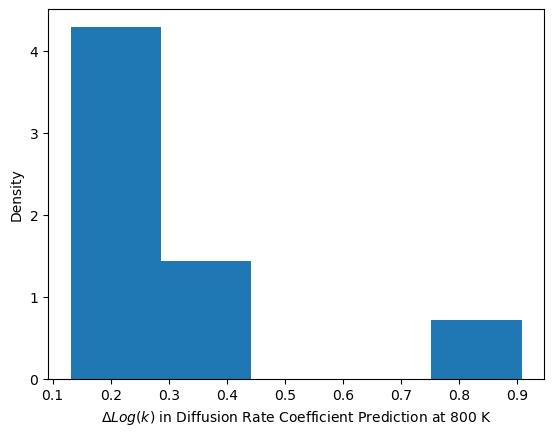

In [18]:
plt.hist(err,bins=5, density=True)
plt.ylabel("Density")
plt.xlabel("$\Delta Log(k)$ in Diffusion Rate Coefficient Prediction at 800 K")

Save and Load Tree

In [19]:
file = "Surface_Diffusion_tree.json"
write_nodes(sidt, file)

In [20]:
nodes = read_nodes(file, class_dict={"SurfaceArrhenius": SurfaceArrhenius, "RateUncertainty": RateUncertainty, "ScalarQuantity": ScalarQuantity})
sidt_loaded = SurfaceDiffusionEstimator(nodes=nodes)

In [21]:
sidt_loaded.evaluate(m)

SurfaceArrhenius(A=(1.47339e+17,'m^2/(mol*s)'), n=-0.00352955, Ea=(14497,'J/mol'), T0=(1,'K'), uncertainty=RateUncertainty(mu=-2.2343238370581275e-15, var=0.033354906245902274, Tref=1000.0, N=2, data_mean=0.0, correlation='Root_N-Sp-2X=1R_1C->O',))